In [31]:
import os

# # Mount Google Drive if not already mounted
# if not os.path.exists('/content/drive'):
#     from google.colab import drive
#     drive.mount('/content/drive')

# # List files in the root of MyDrive
# print(os.listdir('/content/drive/MyDrive'))


In [32]:
import os

# Define the desired path
# desired_path = '/content/drive/MyDrive/AI_in_Science_and_Engineering_HS2025'

# Change the current working directory
# os.chdir(desired_path)

# Verify the current working directory has changed
print(f"Current working directory: {os.getcwd()}")

# Now you can list files directly in this directory
# For example:
# print(os.listdir('.'))


Current working directory: /Users/Tia_987/ETH/AISE/task_3


In [33]:
!pip install torch_cluster torch_scatter rotary_embedding_torch

You should consider upgrading via the '/Users/Tia_987/ETH/AISE/.venv/bin/python3 -m pip install --upgrade pip' command.


In [34]:
import random
import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from torch.optim import AdamW
from dataclasses import dataclass

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Device configuration - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cpu


In [35]:
########################
# Dataloader definition:
########################

class AllenCahnDataset(Dataset):
    def __init__(self, which="train", training_samples=256):

        assert training_samples <= 256

        # Default file:
        self.file_data = "data/AllenCahn_NEW.h5"
        self.reader = h5py.File(self.file_data, 'r')
        print(self.reader)

        # Load normalization constants:
        self.min_data = self.reader['min_u0'][()]
        self.max_data = self.reader['max_u0'][()]
        self.min_model = self.reader['min_u'][()]
        self.max_model = self.reader['max_u'][()]

        if which == "train":
            self.length = training_samples
            self.start = 0
        elif which == "val":
            self.length = 128
            self.start = 256
        elif which == "test":
            self.length = 128
            self.start = 256 + 128

        self.reader = h5py.File(self.file_data, 'r')

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        inputs = torch.from_numpy(self.reader['Sample_' + str(index + self.start)]["input"][:]).type(torch.float32).reshape(1, 64, 64)
        labels = torch.from_numpy(self.reader['Sample_' + str(index + self.start)]["output"][:]).type(torch.float32).reshape(1, 64, 64)

        inputs = (inputs - self.min_data) / (self.max_data - self.min_data)
        labels = (labels - self.min_model) / (self.max_model - self.min_model)

        return inputs, labels

<HDF5 file "AllenCahn_NEW.h5" (mode r)>
<HDF5 file "AllenCahn_NEW.h5" (mode r)>


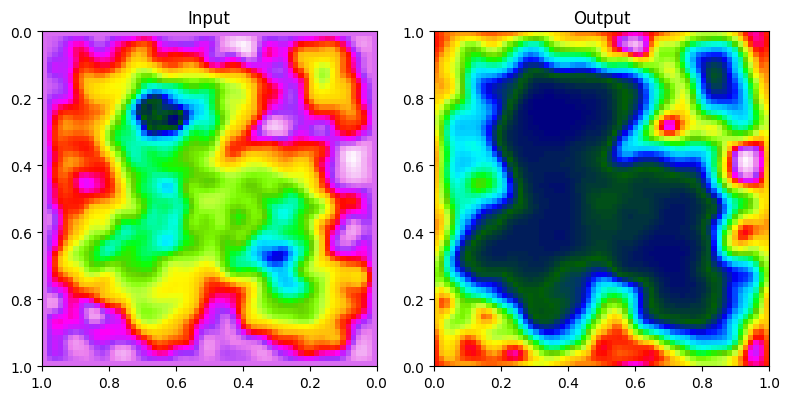

In [ ]:
training_samples = 256
batch_size = 16

train_dataset = AllenCahnDataset(which="train", training_samples=training_samples)
val_dataset = AllenCahnDataset(which="val")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

input, output = next(iter(train_loader))
input_vis = input[0, 0].numpy()
output_vis = output[0, 0].numpy()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(input_vis, cmap="gist_ncar", extent=(0, 1, 0, 1))
axes[0].set_title("Input")
axes[1].imshow(output_vis, cmap="gist_ncar", extent=(0, 1, 0, 1))
axes[1].set_title("Output")
plt.tight_layout()
plt.savefig("tutorial9_gaot_input_output.png", dpi=150, bbox_inches='tight')
plt.show()


In [37]:
########################
# Model definition:
########################

from model.gaot import GAOT
from model.layers.magno import MAGNOConfig
from model.layers.attn import TransformerConfig


# Configuration dataclass
@dataclass
class ModelArgs:
    magno: MAGNOConfig
    transformer: TransformerConfig


@dataclass
class GAOTConfig:
    latent_tokens_size: list
    args: ModelArgs


# Create configuration based on user requirements
magno_config = MAGNOConfig(
    coord_dim=2,
    radius=0.033,
    hidden_size=64,
    mlp_layers=3,
    lifting_channels=64
)

transformer_config = TransformerConfig(
    patch_size=2,
    hidden_size=256
)

model_args = ModelArgs(
    magno=magno_config,
    transformer=transformer_config
)

config = GAOTConfig(
    latent_tokens_size=[64, 64],
    args=model_args
)


# Create coordinate grid for 64x64 regular grid
def create_coordinate_grid(height=64, width=64):
    """
    Create a regular 2D coordinate grid.

    Returns:
        coords: torch.Tensor of shape [height*width, 2]
                Coordinates normalized to [0, 1] x [0, 1]
    """
    y = torch.linspace(-1, 1, height)
    x = torch.linspace(-1, 1, width)

    grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')

    # Flatten and stack to get [N, 2] coordinates
    coords = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

    return coords


# Create coordinate grids (fixed for all samples)
coord_grid = create_coordinate_grid(64, 64).to(device)  # Shape: [4096, 2]
latent_tokens_coord = create_coordinate_grid(64, 64).to(device)  # Shape: [4096, 2]

# Initialize GAOT model
model = GAOT(
    input_size=1,  # input has 1 channel
    output_size=1,  # output has 1 channel
    config=config
).to(device)

print(f"Model initialized: GAOT")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Using torch_cluster for efficient neighbor search
Using torch_cluster for efficient neighbor search
Model initialized: GAOT
Number of parameters: 3396033


In [ ]:
from dataclasses import dataclass
import torch
from model.gaot import GAOT
from model.layers.magno import MAGNOConfig
from model.layers.attn import TransformerConfig

# 1. Update Configurations
magno_config = MAGNOConfig(
    coord_dim=2,      # Still 2D (x, y)
    radius=0.1,       # Increased radius since 972 points are sparser than a 64x64 grid
    hidden_size=64,
    mlp_layers=3,
    lifting_channels=64
)

transformer_config = TransformerConfig(
    patch_size=2,     # This applies to the LATENT grid
    hidden_size=256
)

model_args = ModelArgs(
    magno=magno_config,
    transformer=transformer_config
)

config = GAOTConfig(
    latent_tokens_size=[32, 32], # Reducing latent size often helps with unstructured data
    args=model_args
)

# 2. Latent Grid (The "Internal" Grid)
# The model uses this internal grid to process information. 
# We keep this as a regular grid.
def create_coordinate_grid(height=32, width=32):
    y = torch.linspace(-1, 1, height)
    x = torch.linspace(-1, 1, width)
    grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
    return torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)

# This remains fixed as the "anchor" for the Transformer
latent_tokens_coord = create_coordinate_grid(32, 32).to(device) 

# 3. Initialize Model
model = GAOT(
    input_size=1,  
    output_size=1, 
    config=config
).to(device)

print(f"Model initialized for Unstructured Data (972 points)")

In [38]:
########################
# Training loop:
########################
optimizer = AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=200, eta_min=10**-6)
l = torch.nn.L1Loss()

num_epochs = 20

freq_print = 1
for epoch in range(num_epochs):
    model.train()
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(train_loader):
        # Move data to device
        input_batch = input_batch.to(device)
        output_batch = output_batch.to(device)

        # Reshape from [batch, 1, 64, 64] to [batch, 64*64, 1] for GAOT
        batch_size = input_batch.shape[0]
        pndata = input_batch.reshape(batch_size, 64*64, 1)  # Physical node data
        output_nodes = output_batch.reshape(batch_size, 64*64, 1)

        optimizer.zero_grad()

        # Forward pass through GAOT
        # In fx mode (fixed coordinates), xcoord and latent_tokens_coord don't need batch dimension
        output_pred = model(
            latent_tokens_coord=latent_tokens_coord,  # [N, 2]
            xcoord=coord_grid,  # [N, 2]
            pndata=pndata,  # [batch, N, 1]
            query_coord=None,  # Use xcoord as query
            encoder_nbrs=None,  # Compute neighbors on-the-fly
            decoder_nbrs=None,
            condition=None
        )

        # Compute loss
        loss_f = l(output_pred, output_nodes) / l(output_nodes, torch.zeros_like(output_nodes))
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(train_loader)

    scheduler.step()
    with torch.no_grad():
        model.eval()
        test_relative_l1 = 0.0
        for step, (input_batch, output_batch) in enumerate(val_loader):
            # Move data to device
            input_batch = input_batch.to(device)
            output_batch = output_batch.to(device)

            # Reshape from [batch, 1, 64, 64] to [batch, 64*64, 1]
            batch_size = input_batch.shape[0]
            pndata = input_batch.reshape(batch_size, 64*64, 1)
            output_nodes = output_batch.reshape(batch_size, 64*64, 1)

            output_pred = model(
                latent_tokens_coord=latent_tokens_coord,
                xcoord=coord_grid,
                pndata=pndata,
                query_coord=None,
                encoder_nbrs=None,
                decoder_nbrs=None,
                condition=None
            )

            loss_f = (torch.mean((abs(output_pred - output_nodes))) / torch.mean(abs(output_nodes))) * 100
            test_relative_l1 += loss_f.item()
        test_relative_l1 /= len(val_loader)

    if epoch % freq_print == 0:
        print("## Epoch:", epoch, " ## Train Loss:", train_mse, "## Rel L1 Test Norm:", test_relative_l1, "LR: ", scheduler.get_last_lr())


KeyboardInterrupt: 

In [ ]:
########################
# Plot results:
########################
model.eval()
with torch.no_grad():
    input, output = next(iter(val_loader))

    # Move data to device
    input = input.to(device)
    output = output.to(device)

    # Reshape for GAOT model
    batch_size = input.shape[0]
    pndata = input.reshape(batch_size, 64*64, 1)

    pred = model(
        latent_tokens_coord=latent_tokens_coord,
        xcoord=coord_grid,
        pndata=pndata,
        query_coord=None,
        encoder_nbrs=None,
        decoder_nbrs=None,
        condition=None
    )

    # Reshape back to image format
    pred = pred.reshape(batch_size, 1, 64, 64)

    # Convert to numpy for visualization (move to CPU first)
    input = input[0, 0].cpu().numpy()
    output = output[0, 0].cpu().numpy()
    pred = pred[0, 0].cpu().detach().numpy()

vmin = np.min(output)
vmax = np.max(output)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(input, cmap="gist_ncar", extent=(0, 1, 0, 1))
axes[0].set_title("Input")
axes[1].imshow(output, cmap="gist_ncar", extent=(0, 1, 0, 1), vmin=vmin, vmax=vmax)
axes[1].set_title("Ground Truth")
axes[2].imshow(pred, cmap="gist_ncar", extent=(0, 1, 0, 1), vmin=vmin, vmax=vmax)
axes[2].set_title("Prediction")
plt.tight_layout()
plt.savefig("tutorial9_gaot.png", dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
########################
# PCA visualization of encoder and processor outputs:
########################
from sklearn.decomposition import PCA

print("\n" + "="*50)
print("PCA Visualization of Intermediate Features")
print("="*50)

model.eval()
with torch.no_grad():
    input, output = next(iter(val_loader))
    input = input.to(device)
    output = output.to(device)

    # Reshape for GAOT model
    batch_size = input.shape[0]
    pndata = input.reshape(batch_size, 64*64, 1)

    # Extract encoder output
    encoder_output = model.encode(
        x_coord=coord_grid,
        pndata=pndata,
        latent_tokens_coord=latent_tokens_coord,
        encoder_nbrs=None
    )
    print(f"Encoder output shape: {encoder_output.shape}")  # [batch, N, channels]

    # Extract processor output
    processor_output = model.process(
        rndata=encoder_output,
        condition=None
    )
    print(f"Processor output shape: {processor_output.shape}")  # [batch, N, channels]

    # Move to CPU and convert to numpy for PCA
    # Take the first sample from the batch
    encoder_features = encoder_output[0].cpu().numpy()  # [N, channels]
    processor_features = processor_output[0].cpu().numpy()  # [N, channels]
    # Apply PCA to reduce to 2 components
    pca_encoder = PCA(n_components=2)
    encoder_pca = pca_encoder.fit_transform(encoder_features)  # [N, 2]

    pca_processor = PCA(n_components=2)
    processor_pca = pca_processor.fit_transform(processor_features)  # [N, 2]

    print(f"\nEncoder PCA explained variance ratio: {pca_encoder.explained_variance_ratio_}")
    print(f"Processor PCA explained variance ratio: {pca_processor.explained_variance_ratio_}")

    encoder_pca_reshaped = encoder_pca.reshape(64, 64, 2)
    processor_pca_reshaped = processor_pca.reshape(64, 64, 2)

    input_vis = input[0, 0].cpu().numpy()

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Row 1: Encoder outputs
    im0 = axes[0, 0].imshow(input_vis, cmap="viridis", extent=(0, 1, 0, 1))
    axes[0, 0].set_title("Input Data")
    plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)

    im1 = axes[0, 1].imshow(encoder_pca_reshaped[:, :, 0], cmap="RdBu_r", extent=(0, 1, 0, 1))
    axes[0, 1].set_title(f"Encoder PC1 ({pca_encoder.explained_variance_ratio_[0]*100:.1f}%)")
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

    im2 = axes[0, 2].imshow(encoder_pca_reshaped[:, :, 1], cmap="RdBu_r", extent=(0, 1, 0, 1))
    axes[0, 2].set_title(f"Encoder PC2 ({pca_encoder.explained_variance_ratio_[1]*100:.1f}%)")
    plt.colorbar(im2, ax=axes[0, 2], fraction=0.046, pad=0.04)

    # Row 2: Processor outputs
    im3 = axes[1, 0].imshow(input_vis, cmap="viridis", extent=(0, 1, 0, 1))
    axes[1, 0].set_title("Input Data")
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

    im4 = axes[1, 1].imshow(processor_pca_reshaped[:, :, 0], cmap="RdBu_r", extent=(0, 1, 0, 1))
    axes[1, 1].set_title(f"Processor PC1 ({pca_processor.explained_variance_ratio_[0]*100:.1f}%)")
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)

    im5 = axes[1, 2].imshow(processor_pca_reshaped[:, :, 1], cmap="RdBu_r", extent=(0, 1, 0, 1))
    axes[1, 2].set_title(f"Processor PC2 ({pca_processor.explained_variance_ratio_[1]*100:.1f}%)")
    plt.colorbar(im5, ax=axes[1, 2], fraction=0.046, pad=0.04)

    fig.text(0.02, 0.75, 'Encoder Features', va='center', rotation='vertical', fontsize=14, fontweight='bold')
    fig.text(0.02, 0.25, 'Processor Features', va='center', rotation='vertical', fontsize=14, fontweight='bold')

    plt.tight_layout(rect=[0.03, 0, 1, 1])
    plt.savefig("tutorial9_gaot_pca_visualization.png", dpi=150, bbox_inches='tight')
    plt.show()